In [1]:
import os
import torch
import json
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import grad
from models.vit import ViT
import utils
from PIL import Image
import my_dataset
from pathlib import Path
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from models_DLA.dla_simple import SimpleDLA

# 该文件用于得到每个训练样本的tracin score，并进行排序，最终写入txt文件

In [2]:
size = 32 # 图片尺寸

num_classes = 10 # 类别数

root = "./weights/model-" #checkpoint路径
weight_pth = 20 #第n个checkpoint

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# 初始化模型
# model = ViT(
#     image_size = size,
#     patch_size = 4,
#     num_classes = num_classes,
#     dim = 512,
#     depth = 6,
#     heads = 8,
#     mlp_dim = 512,
#     dropout = 0.1,
#     emb_dropout = 0.1
# ).to(device)
model = SimpleDLA().to(device)


In [5]:
# 读取数据
# test_data = utils.read_file("./forgetting/result/forget.txt")
train_data = utils.read_file("../cifar10/train_data.txt")

In [6]:
# 读取测试数据在正常训练时保存的信息
data = utils.read_yaml("./train_detail/val_data_LDA.yaml")

In [7]:
# 根据yaml文件，计算每个测试样本的难度系数。wrong = 测试样本在第N个epoch前出错的次数 * 1 + 测试样本在第N个epoch前出错的次数 * 0。before，after暂未用到。path为文件路径，与wrong一一对应
wrong, before, after, path = utils.cal_wrong(data, weight_pth, 1, 0)

# 根据wrong，对wrong和path进行排序
wrong_sorted, path_sorted = utils.sort_list(wrong, path, 1)

In [8]:
# # 删除那些始终无法被正确识别的样本
# if eliminate == "eliminate":
#     for path in wrong_data:
#         if path in path_sorted:
#             path_sorted.remove(path)

In [10]:
# 根据排序后的path，区分出hard，easy数据。classify参数代表每个类的数量相同
hard_data, easy_data = utils.split_easy_hard(path_sorted, 0.3, 0.3, classify = True)

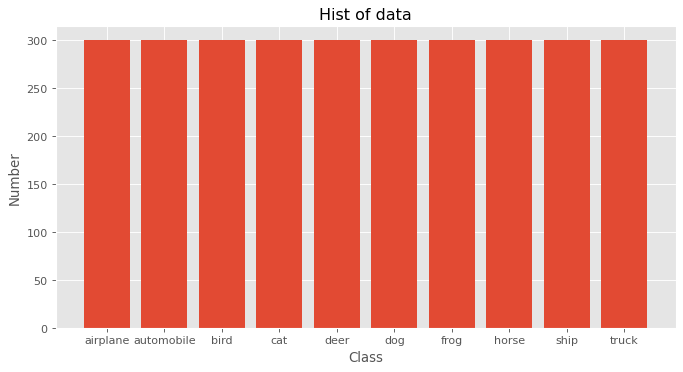

In [11]:
# 绘制hard_data的直方图。验证每个类数量相同
utils.draw_hist(hard_data)

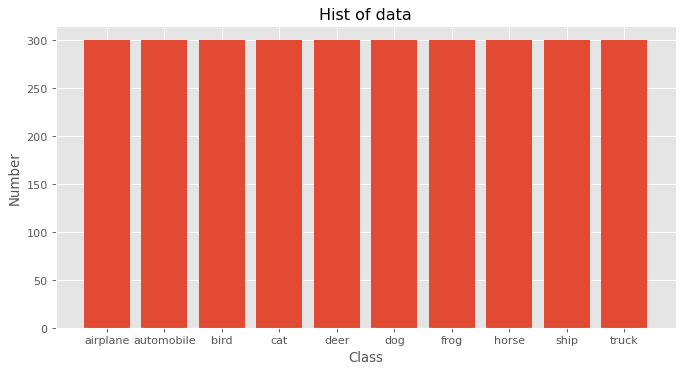

In [12]:
utils.draw_hist(easy_data)

# 使用hard数据进行训练，根据tracin进行排序，保存至保存到train_result_DLA文件夹中

In [13]:
# 定义data transform，与正常训练时保持一致
data_transform = {
        "train": transforms.Compose([
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.Resize(32),
                                    transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
        "test": transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])}

# 生成数据集和测试数据集
test_dataset = my_dataset.MyDataSet_CIFAR_Tracin(images_path=hard_data,
                        transform=data_transform["test"])
train_dataset = my_dataset.MyDataSet_CIFAR_Tracin(images_path=train_data,
                        transform=data_transform["train"])

# 创建dataloader类，其中trainloader的batch为1
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size = 1,
                                            collate_fn=train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size = 32,
                                            shuffle=True,
                                            pin_memory=True,
                                            collate_fn=test_dataset.collate_fn)

# 定义损失函数
loss_function = torch.nn.CrossEntropyLoss()

# score_list用来保存每个样本在0-n个epoch中tracin的和，长度为len(train_data)。path_list用来保存训练数据的路径
score_list = []
path_list = train_data
for index, p in enumerate(path_list):
    score_list.append(0.)
# 对0-n个epoch进行tracin的计算并求和
bar = tqdm(range(weight_pth))
for index, ep in enumerate(bar):


    # 加载当前epoch保存的pth
    checkpoint = torch.load('./weights_LDA/checkpoint-' + str(ep + 1) + '.pth.tar')
    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])

    model.eval()
    # val_loader = tqdm(val_loader)


    # 计算测试数据的grad_z_test
    for step, data in enumerate(val_loader):
        images, labels, path = data
        result_train = model(images.to(device))
        loss_train = loss_function(result_train, labels.to(device))
        grad_z_test = grad(loss_train, model.parameters())
        grad_z_test = utils.get_gradient(grad_z_test, model)


    # 根据grad_z_test，对每个训练数据计算tracin
    # train_loader = tqdm(train_loader)
    for step, data in enumerate(train_loader):
        images, labels, path = data
        result = model(images.to(device))
        loss_test = loss_function(result, labels.to(device))
        grad_z_train = grad(loss_test, model.parameters())
        grad_z_train = utils.get_gradient(grad_z_train, model)
        score = utils.tracin_get(grad_z_test, grad_z_train)


        # 根据当前训练数据的路径，在path_list中找到相应的下标，再在score_list的相应位置相加
        score_list[int(path_list.index(path[0]))] = score_list[int(path_list.index(path[0]))] + score
# 根据score_list对score_list和path_list进行排序；并将排序后的结果保存至path_lists和score_lists
path_lists = []
score_lists = []
for index in utils.get_sorted_index(score_list, 1):
    path_lists.append(path_list[index])
    score_lists.append(score_list[index].item())
# 写入txt文件
with open("./train_result_DLA/hard_20.txt", 'w') as file:
        file.truncate(0)
        for data in path_lists:
            file.write(str(data) + '\n')
        print("[Success] Write {0} lines of data in file {1}".format(len(path_lists), "./train_result_DLA/hard_20.txt"))

100%|██████████| 20/20 [2:54:45<00:00, 524.25s/it]  


[Success] Write 35000 lines of data in file ./train_result_DLA/forget/hard_20.txt


# 使用easy数据进行计算tracin，根据tracin进行排序，保存到train_result_DLA文件夹中

In [14]:
# 生成数据集和测试数据集
test_dataset = my_dataset.MyDataSet_CIFAR_Tracin(images_path=easy_data,
                        transform=data_transform["test"])
train_dataset = my_dataset.MyDataSet_CIFAR_Tracin(images_path=train_data,
                        transform=data_transform["train"])

# 创建dataloader类，其中trainloader的batch为1
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size = 1,
                                            collate_fn=train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size = 32,
                                            shuffle=True,
                                            pin_memory=True,
                                            collate_fn=test_dataset.collate_fn)

# 定义损失函数
loss_function = torch.nn.CrossEntropyLoss()

# score_list用来保存每个样本在0-n个epoch中tracin的和，长度为len(train_data)。path_list用来保存训练数据的路径
score_list = []
path_list = train_data
for index, p in enumerate(path_list):
    score_list.append(0.)
# 对0-n个epoch进行tracin的计算并求和
bar = tqdm(range(weight_pth))
for index, ep in enumerate(bar):


    # 加载当前epoch保存的pth
    checkpoint = torch.load('./weights_LDA/checkpoint-' + str(ep + 1) + '.pth.tar')
    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])

    model.eval()
    # val_loader = tqdm(val_loader)


    # 计算测试数据的grad_z_test
    for step, data in enumerate(val_loader):
        images, labels, path = data
        result_train = model(images.to(device))
        loss_train = loss_function(result_train, labels.to(device))
        grad_z_test = grad(loss_train, model.parameters())
        grad_z_test = utils.get_gradient(grad_z_test, model)


    # 根据grad_z_test，对每个训练数据计算tracin
    # train_loader = tqdm(train_loader)
    for step, data in enumerate(train_loader):
        images, labels, path = data
        result = model(images.to(device))
        loss_test = loss_function(result, labels.to(device))
        grad_z_train = grad(loss_test, model.parameters())
        grad_z_train = utils.get_gradient(grad_z_train, model)
        score = utils.tracin_get(grad_z_test, grad_z_train)


        # 根据当前训练数据的路径，在path_list中找到相应的下标，再在score_list的相应位置相加
        score_list[int(path_list.index(path[0]))] = score_list[int(path_list.index(path[0]))] + score
# 根据score_list对score_list和path_list进行排序；并将排序后的结果保存至path_lists和score_lists
path_lists = []
score_lists = []
for index in utils.get_sorted_index(score_list, 1):
    path_lists.append(path_list[index])
    score_lists.append(score_list[index].item())
# 写入txt文件
with open("./train_result_DLA/easy_20.txt", 'w') as file:
        file.truncate(0)
        for data in path_lists:
            file.write(str(data) + '\n')
        print("[Success] Write {0} lines of data in file {1}".format(len(path_lists), "./train_result_DLA/easy_20.txt"))

100%|██████████| 20/20 [2:54:01<00:00, 522.10s/it]  


[Success] Write 35000 lines of data in file ./train_result_DLA/forget/easy_20.txt
